###  Carregando as bibliotecas

In [ ]:
import pandas as pd
import sys
import os
import seaborn as sns
import locale

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '')))
from utils.utils import ler_csv

### Carregando os datasets

In [6]:
df_clientes = ler_csv(filepath='../datasets/clientes.csv')
df_estabelecimentos = ler_csv(filepath='../datasets/estabelecimentos.csv')
df_relacao_transacao_cliente = ler_csv(filepath='../datasets/relacao_transacao_cliente.csv')
df_transacoes = ler_csv(filepath='../datasets/transacoes.csv')

Arquivo '../datasets/clientes.csv' lido com sucesso!
Arquivo '../datasets/estabelecimentos.csv' lido com sucesso!
Arquivo '../datasets/relacao_transacao_cliente.csv' lido com sucesso!
Arquivo '../datasets/transacoes.csv' lido com sucesso!


### Merge das Tabelas

Este modelo segue a estrutura star schema, típica de data warehouses, com:
- Tabelas de dimensão (clientes, estabelecimentos, relação_transação_cliente) armazenando atributos descritivos.
- Tabela fato (transações) centralizando os eventos mensuráveis (valores, status).

Será realizado um MERGE/JOIN entre as tabelas de dimensão e a tabela fato para criar uma tabela consolidada.

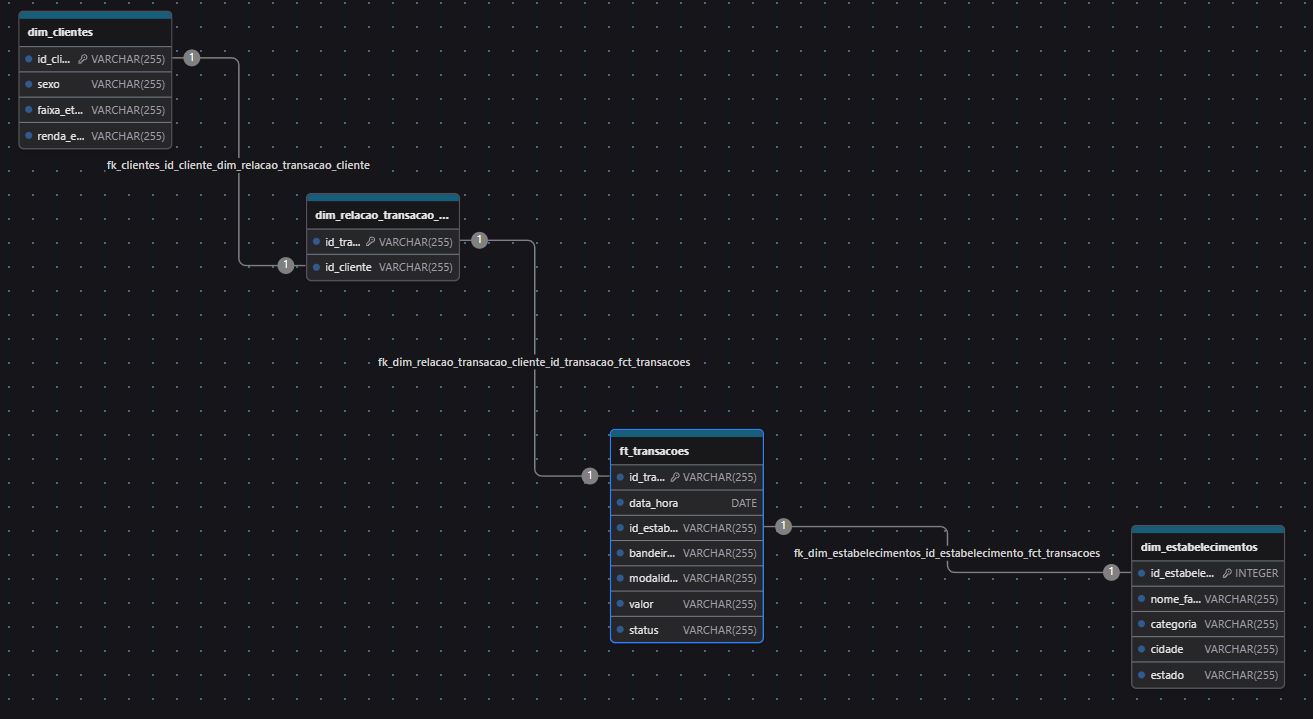

In [31]:
# 1. Merge da relação transação-cliente com os clientes
df_clientes_transacoes = pd.merge(
    df_relacao_transacao_cliente,
    df_clientes,
    on='id_cliente',
    how='left'
)

In [33]:
# 2. Merge do resultado anterior com as transações
df_transacoes_completo = pd.merge(
    df_transacoes,
    df_clientes_transacoes,
    on='id_transacao',
    how='left'
)

In [35]:
# 3. Merge com estabelecimentos
df = pd.merge(
    df_transacoes_completo,
    df_estabelecimentos,
    on='id_estabelecimento',
    how='left'
)

In [38]:
df

,id_transacao,data_hora,id_estabelecimento,bandeira_cartao,modalidade,valor,status,id_cliente,sexo,faixa_etaria,renda_estimada,nome_fantasia,categoria,cidade,estado
0,trx_0,2024-06-24 23:00:00,estab_5,Mastercard,crédito,13.48,aprovada,cli_344,F,18-25,2k-5k,Carvalho S.A.,mercado,Alves,AP
1,trx_1,2024-07-20 07:00:00,estab_24,Hipercard,débito,541.70,recusada,cli_309,M,36-45,5k-10k,da Cruz Mendes - ME,restaurante,Porto de da Cunha,TO
2,trx_2,2024-04-25 08:00:00,estab_30,Elo,débito,772.15,aprovada,cli_11,F,46-60,5k-10k,Araújo - EI,farmácia,Dias de Gonçalves,MG
3,trx_3,2024-05-12 18:00:00,estab_8,Mastercard,débito,751.27,aprovada,cli_64,M,18-25,10k+,Dias - ME,farmácia,da Rocha do Amparo,PB
4,trx_4,2024-04-17 05:00:00,estab_19,Elo,débito,906.99,estornada,cli_181,F,26-35,<2k,Novais Leão S.A.,vestuário,Porto da Serra,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,trx_9995,2024-10-08 17:00:00,estab_9,Visa,débito,1311.83,aprovada,cli_412,M,60+,5k-10k,Machado,eletrodomésticos,da Costa,PA
9996,trx_9996,2024-09-11 14:00:00,estab_34,Hipercard,débito,1047.56,aprovada,cli_79,M,46-60,2k-5k,Cavalcante,farmácia,Azevedo,MS
9997,trx_9997,2024-10-16 19:00:00,estab_35,Visa,crédito,769.11,recusada,cli_418,M,60+,<2k,Rodrigues,eletrodomésticos,Cavalcanti de Cunha,TO
9998,trx_9998,2024-01-05 10:00:00,estab_32,Mastercard,débito,471.24,aprovada,cli_274,M,26-35,<2k,Monteiro Novais - EI,vestuário,Rios,BA


In [39]:
df.columns

Index(['id_transacao', 'data_hora', 'id_estabelecimento', 'bandeira_cartao',
       'modalidade', 'valor', 'status', 'id_cliente', 'sexo', 'faixa_etaria',
       'renda_estimada', 'nome_fantasia', 'categoria', 'cidade', 'estado'],
      dtype='object')

### Tratamento e Engenharia de Dados

In [ ]:
# Limpeza de dados (limpeza de dados (valores ausentes, formatos, etc.)

In [40]:
# Crie a coluna mês da transação
df['mes_transacao'] = pd.to_datetime(df['data_hora']).dt.month

In [ ]:
# Indicador de transação aprovada
# esse pedido não fez muito sentido

In [45]:
# valor acumulado por cliente
df['valor_acumulado_cliente'] = df.groupby('id_cliente')['valor'].cumsum()

In [ ]:
# valor acumulado por estabelecimento
df['valor_acumulado_estabelecimento'] = df.groupby('id_estabelecimento')['valor'].cumsum()

In [50]:
# valor acumulado por cliente estabelecimento (verificar)
df[['id_transacao', 'mes_transacao', 'valor_acumulado_cliente', 'valor_acumulado_estabelecimento']].head()

,id_transacao,mes_transacao,valor_acumulado_cliente,valor_acumulado_estabelecimento
0,trx_0,6,13.48,13.48
1,trx_1,7,541.70,541.70
2,trx_2,4,772.15,772.15
3,trx_3,5,751.27,751.27
4,trx_4,4,906.99,906.99


### KPI e Análises

In [ ]:
# groupbys

#### Carregando as bibliotecas e configurações

Notebook Color Scheme: 


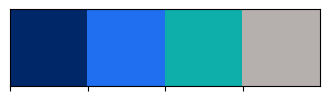

In [10]:
# color scheme
class clr:
    S = '\033[1m' + '\033[96m'
    E = '\033[0m'

my_colors = ['#002768', '#1F6FF0', '#0eafaa', '#B5B0AE']
sns.palplot(sns.color_palette(my_colors))
print(clr.S + "Notebook Color Scheme: " + clr.E)

In [11]:
# Configurar locale para usar ponto como separador de milhar nos gráficos
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

Ao responder as perguntas do time de negócio, além das consultas, plotarei gráficos para uma abordagem visual intuitiva para análise de dados.

Para evitar repetição no código, criei uma classe para plotar gráficos porque isso organiza o código em um único lugar, facilita a reutilização, centraliza ajustes de estilo e melhora a manutenção. Assim, evito repetição de código e deixo a estrutura mais limpa e clara para leitura.

In [13]:
from utils.plot_config import configure_plot_style, PlotUtils
# Configurações globais de estilo para exibição no notebook
configure_plot_style()
%matplotlib inline

# Instanciando a classe
plotutils = PlotUtils()